# 002: Describe and understand dataset

In [1]:
import sys

import numpy as np
from matplotlib import pyplot as plt

sys.path.append("../")
import helpers

%load_ext autoreload
%autoreload 2

In [2]:
x_train, x_test, y_train, train_ids, test_ids = helpers.load_csv_data("../data/dataset", sub_sample=False)

# Target description

In [3]:
print(f"y_train.shape: {y_train.shape}")
print(f"The target contains these values: {np.unique(y_train)}")
unique, counts = np.unique(y_train, return_counts=True)
percentages = counts / counts.sum() * 100
for label, pct in zip(unique, percentages):
    print(f"Label {label}: {pct:.2f}%")


y_train.shape: (328135,)
The target contains these values: [-1  1]
Label -1: 91.17%
Label 1: 8.83%


# Feature description

x_train.shape: (328135, 321)
x_test.shape: (109379, 321)
Features with missing values: 239 / 321 (74.5%)
Featurs with more than 90\% missing data: 30.8


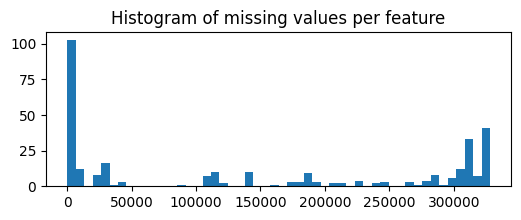

In [4]:
print(f"x_train.shape: {x_train.shape}")
print(f"x_test.shape: {x_test.shape}")
missing_values = (np.isnan(x_train).mean(axis=0))
print(f"Features with missing values: {(missing_values>0).sum()} / {x_train.shape[1]} ({(missing_values > 0.00).mean()*100:.1f}%)")
print(f"Featurs with more than 90\% missing data: {(missing_values > 0.9).mean()*100:.1f}")

plt.figure(figsize=(6, 2))
plt.hist(np.isnan(x_train).sum(axis=0), bins=50)
plt.title("Histogram of missing values per feature")
plt.show()

In [51]:
with open("../data/dataset/x_train.csv", "r") as f:
    feature_names = f.readline().strip().split(",")
print(feature_names)

['Id', '_STATE', 'FMONTH', 'IDATE', 'IMONTH', 'IDAY', 'IYEAR', 'DISPCODE', 'SEQNO', '_PSU', 'CTELENUM', 'PVTRESD1', 'COLGHOUS', 'STATERES', 'CELLFON3', 'LADULT', 'NUMADULT', 'NUMMEN', 'NUMWOMEN', 'CTELNUM1', 'CELLFON2', 'CADULT', 'PVTRESD2', 'CCLGHOUS', 'CSTATE', 'LANDLINE', 'HHADULT', 'GENHLTH', 'PHYSHLTH', 'MENTHLTH', 'POORHLTH', 'HLTHPLN1', 'PERSDOC2', 'MEDCOST', 'CHECKUP1', 'BPHIGH4', 'BPMEDS', 'BLOODCHO', 'CHOLCHK', 'TOLDHI2', 'CVDSTRK3', 'ASTHMA3', 'ASTHNOW', 'CHCSCNCR', 'CHCOCNCR', 'CHCCOPD1', 'HAVARTH3', 'ADDEPEV2', 'CHCKIDNY', 'DIABETE3', 'DIABAGE2', 'SEX', 'MARITAL', 'EDUCA', 'RENTHOM1', 'NUMHHOL2', 'NUMPHON2', 'CPDEMO1', 'VETERAN3', 'EMPLOY1', 'CHILDREN', 'INCOME2', 'INTERNET', 'WEIGHT2', 'HEIGHT3', 'PREGNANT', 'QLACTLM2', 'USEEQUIP', 'BLIND', 'DECIDE', 'DIFFWALK', 'DIFFDRES', 'DIFFALON', 'SMOKE100', 'SMOKDAY2', 'STOPSMK2', 'LASTSMK2', 'USENOW3', 'ALCDAY5', 'AVEDRNK2', 'DRNK3GE5', 'MAXDRNKS', 'FRUITJU1', 'FRUIT1', 'FVBEANS', 'FVGREEN', 'FVORANG', 'VEGETAB1', 'EXERANY2', 'EXR

In [52]:
with open("../data/feature_names.csv", "w") as out_f:
    for name in feature_names:
        out_f.write(f"{name}\n")

In [8]:
# Calculate percentage of missing data for each feature (excluding the ID column)
missing_percentages = np.isnan(x_train).sum(axis=0) / x_train.shape[0] * 100

with open("../data/missing_percentages.csv", "w") as out_f:
    for name, pct in zip(feature_names, missing_percentages):
        out_f.write(f"{pct:.1f}\n")

In [53]:
# Determine feature types: continuous or categorical, and count categories for categorical features

def feature_type_and_categories(x, feature_names, threshold=20):
    feature_info = []
    for i, name in enumerate(feature_names[1:]):  # Skip ID column
        col = x[:, i]
        # Remove NaNs for unique count
        unique_vals = np.unique(col[~np.isnan(col)])
        n_unique = len(unique_vals)
        # Heuristic: if unique values <= threshold, treat as categorical
        if n_unique <= threshold:
            feature_type = "categorical"
            info = f"{name}: {feature_type}, {n_unique} categories ({unique_vals})"
        else:
            feature_type = "continuous"
            info = f"{name}: {feature_type}"
        feature_info.append(info)
    return feature_info

feature_summary = feature_type_and_categories(x_train, feature_names)
for info_train in feature_summary:
    print(info_train)

_STATE: continuous
FMONTH: categorical, 12 categories ([ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12.])
IDATE: continuous
IMONTH: categorical, 12 categories ([ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12.])
IDAY: continuous
IYEAR: categorical, 2 categories ([2015. 2016.])
DISPCODE: categorical, 2 categories ([1100. 1200.])
SEQNO: continuous
_PSU: continuous
CTELENUM: categorical, 1 categories ([1.])
PVTRESD1: categorical, 2 categories ([1. 2.])
COLGHOUS: categorical, 1 categories ([1.])
STATERES: categorical, 1 categories ([1.])
CELLFON3: categorical, 2 categories ([1. 2.])
LADULT: categorical, 2 categories ([1. 2.])
NUMADULT: categorical, 16 categories ([ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 14. 15. 18. 20.])
NUMMEN: categorical, 12 categories ([ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 18.])
NUMWOMEN: categorical, 11 categories ([ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.])
CTELNUM1: categorical, 1 categories ([1.])
CELLFON2: categorical, 1 categories ([1.])
CADULT: 

In [12]:
feature_summary_test = feature_type_and_categories(x_test, feature_names)
for info in zip(feature_summary, feature_summary_test):
    if info[0] != info[1]:
        print(f"Train: {info[0]} | Test: {info[1]}")

Train: NUMADULT: categorical, 16 categories ([ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 14. 15. 18. 20.]) | Test: NUMADULT: categorical, 12 categories ([ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 12. 16.])
Train: NUMMEN: categorical, 12 categories ([ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 18.]) | Test: NUMMEN: categorical, 8 categories ([0. 1. 2. 3. 4. 5. 6. 8.])
Train: NUMWOMEN: categorical, 11 categories ([ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]) | Test: NUMWOMEN: categorical, 9 categories ([0. 1. 2. 3. 4. 5. 6. 7. 8.])
Train: CELLFON2: categorical, 1 categories ([1.]) | Test: CELLFON2: categorical, 2 categories ([1. 2.])
Train: CHILDREN: continuous | Test: CHILDREN: categorical, 15 categories ([ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 12. 32. 41. 88. 99.])
Train: VIPRFVS2: categorical, 7 categories ([1. 2. 3. 4. 5. 7. 9.]) | Test: VIPRFVS2: categorical, 6 categories ([1. 2. 3. 4. 5. 7.])
Train: VINOCRE2: categorical, 10 categories ([ 1.  2.  3.  4.  5.  6.  7.  8. 77. 99.

In [176]:
np.sum(["_" in name for name in feature_names])

np.int64(100)

In [ ]:
def get_raw_data():
    return x_train_orig, x_test_orig, y_train_orig, train_ids, test_ids

# Feature visualization

In [98]:
train = np.load("../data/dataset_prep/train.npz")
x_train = train["x_train"]
y_train = train["y_train"]

In [99]:
# Missingness
missing_perc = np.isnan(x_train).mean(axis=0)
sorted_missing = missing_perc[np.argsort(missing_perc)]

In [101]:
# Explained Variance
from preprocessing import impute_missing_values
X = impute_missing_values(x_train, x_train)
mean = X.mean(axis=0)
std = X.std(axis=0)
X[:,std>0] = (X[:,std>0] - mean[std>0]) / std[std>0]
X_centered = X - np.mean(X, axis=0)
cov_matrix = np.cov(X_centered, rowvar=False)  # shape (n_features, n_features)
eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
idx = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]
explained_variance_ratio = eigenvalues / np.sum(eigenvalues)
cumulative_variance = np.cumsum(explained_variance_ratio)

In [172]:
np.where(cumulative_variance == 1)

(array([302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314,
        315, 316, 317, 318, 319, 320]),)

In [195]:
# Variable types
# Number of unique values per feature and variable types
variable_type = []
with open("../data/variable_type.txt", "r") as f:
    for line in f:
        line = line.strip().strip('"')  # remove whitespace and surrounding quotes
        # split by comma and convert to int
        if line == "":
            variable_type.append([])
        else:
            variable_type.append(line)
num_unique = []
for i in range(x_train.shape[1]):  # Skip ID column
        col = x_train[:, i] # skip ID column
        unique_vals = np.unique(col[~np.isnan(col)])
        n_unique = len(unique_vals)
        num_unique.append(n_unique)

unique_types = ["binary","nominal","ordinal","continuous"]  # preserve order
# Map variable_type strings to numeric codes following unique_types order
type_to_idx = {t: i for i, t in enumerate(unique_types)}
variable_idx = np.array([type_to_idx.get(t, len(unique_types)) for t in variable_type])

# Ensure num_unique is an array for lexsort
num_unique = np.array(num_unique)
order = np.lexsort((num_unique, variable_idx))
sorted_unique_vals = np.array(num_unique)[order]
sorted_var_types = np.array(variable_type)[order]

In [ ]:
from collections import Counter
type_counts = Counter(sorted_var_types)

Legend


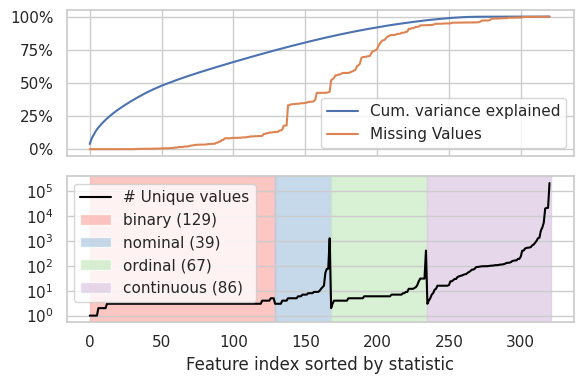

In [197]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter, MaxNLocator
from matplotlib.patches import Patch

sns.set(style="whitegrid")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 4), sharex=True)

# --- Subplot 1: cumulative variance & missing values (percentage) ---
sns.lineplot(x=range(len(cumulative_variance)), y=cumulative_variance, ax=ax1, label="Cum. variance explained")
sns.lineplot(x=range(len(sorted_missing)), y=sorted_missing, ax=ax1, label="Missing Values")

ax1.set_ylabel("")
ax1.yaxis.set_major_formatter(PercentFormatter(xmax=1))
ax1.legend(loc="lower right")
ax1.yaxis.set_major_locator(MaxNLocator(nbins=5))

# --- Subplot 2: unique values (log scale) ---
sns.lineplot(x=range(len(sorted_unique_vals)), y=sorted_unique_vals, ax=ax2, color="black", label="# Unique values")

ax2.set_ylabel("")
yticks = np.logspace(
    np.log10(1),
    np.log10(100000),
    6
)
ax2.set_yscale("log")
ax2.set_yticks(yticks)
#ax2.get_yaxis().set_major_formatter(plt.LogFormatter())  # Show normal numbers, not scientific notation


colors = plt.cm.Pastel1.colors  # use soft, distinct colors
color_map = {t: colors[i % len(colors)] for i, t in enumerate(unique_types)}

for i, t in enumerate(sorted_var_types):
    if i == 0 or sorted_var_types[i] != sorted_var_types[i - 1]:
        start = i
        # Find where this region ends
        end = next((j for j in range(i + 1, len(sorted_var_types)) if sorted_var_types[j] != t), len(sorted_var_types))
        ax2.axvspan(start, end, color=color_map[t], alpha=0.75, zorder=0)
        
ax2.set_xlabel("Feature index sorted by statistic")

patches = [Patch(facecolor=color_map[t], alpha=0.75, label=f"{t} ({type_counts[t]})") for t in unique_types]
line_handles, _ = ax2.get_legend_handles_labels()
print(ax2.get_legend())
ax2.legend(handles=line_handles + patches, loc="upper left", frameon=True)

ax2.grid(axis='x')
plt.tight_layout()
plt.savefig("../results/feature_statistics_overview.pdf")
plt.show()


In [4]:
from visualizations import plot_class_distribution_by_group

In [ ]:
for i, feature_name in enumerate(feature_names[1:51]):  # Skip ID column
    print(i, feature_name)
    plot_class_distribution_by_group(y_train, x_train[:,i], annotate=False)
    plt.show()

In [40]:
def plot_class_distribution_by_group(y, group_attr, annotate=True):
    mask = ~np.isnan(group_attr)
    group_clean = group_attr[mask]
    y_clean = y[mask]

    # Compute proportions per group
    unique_groups = np.unique(group_clean)
    proportions = []
    for g in unique_groups:
        vals = y_clean[group_clean == g]
        pos_ratio = np.mean(vals == 1)
        proportions.append(pos_ratio)
    proportions = np.array(proportions)
    # Create a color map based on the relation (-1 ↔ 1)
    cmap = plt.cm.seismic
    vmin, vmax = proportions.min(), proportions.max()
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    colors = [cmap(norm(p)) for p in proportions]

    # Plot one bar per group, colored by ratio
    bars = plt.bar(unique_groups, [1]*len(unique_groups), color=colors)

    if annotate:
        for i, p in enumerate(proportions):
            plt.text(unique_groups[i], 0.5, f"{p*100:.0f}%", 
                     ha='center', va='center', color='black', fontsize=9)

    plt.title("Class Relation (-1 vs 1) by Group")
    plt.xlabel("Group")
    plt.ylabel("Relation (color-coded)")
    sm = plt.cm.ScalarMappable(cmap=cmap)
    sm.set_array([])
    cbar = plt.colorbar(sm)
    cbar.ax.set_ylabel("Proportion of +1")
    cbar.set_ticks([0, 0.5, 1])
    cbar.set_ticklabels([f"{vmin:.2f}", f"{(vmin+vmax)/2:.2f}", f"{vmax:.2f}"])
    plt.show()

0 _STATE


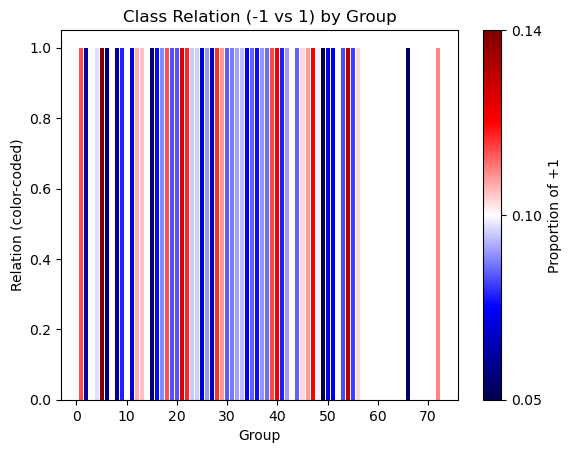

1 FMONTH


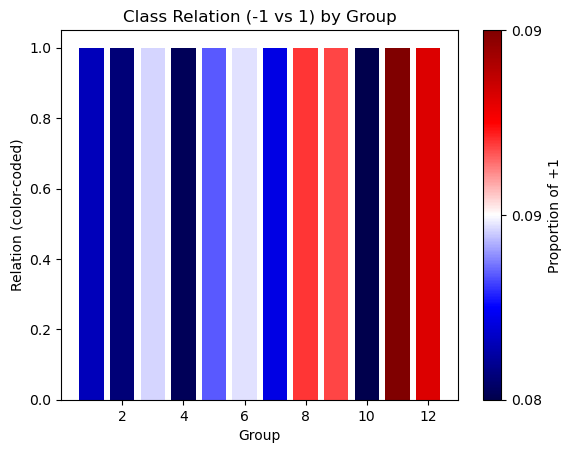

2 IDATE


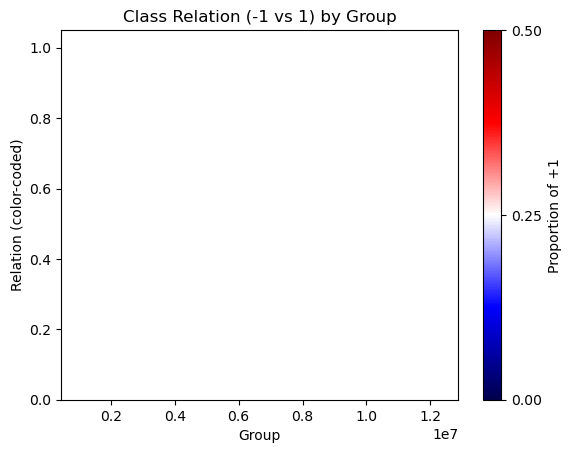

3 IMONTH


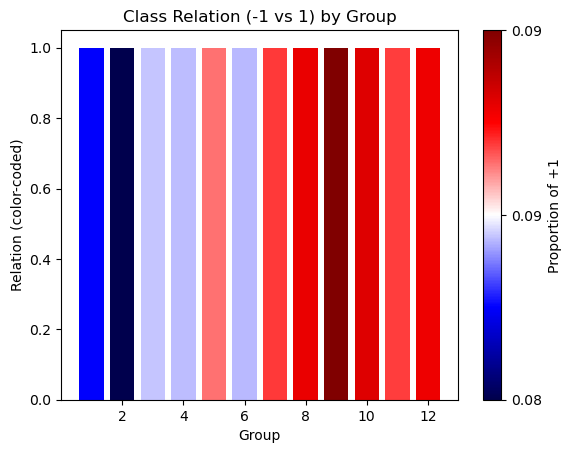

4 IDAY


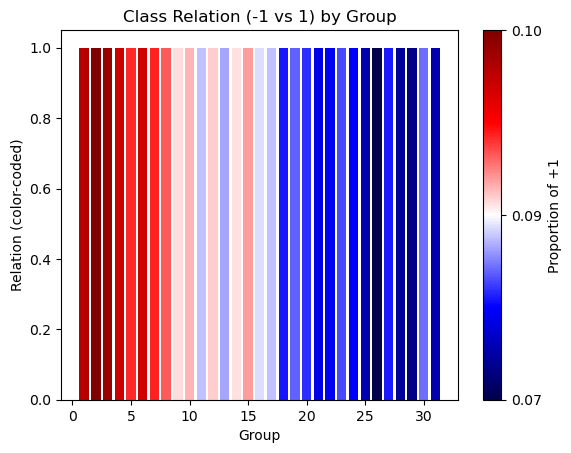

5 IYEAR


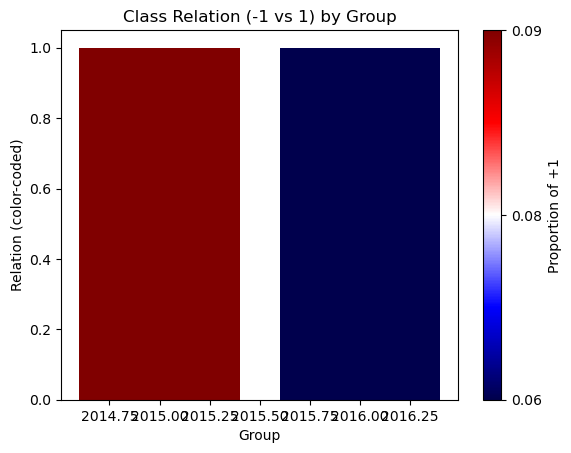

6 DISPCODE


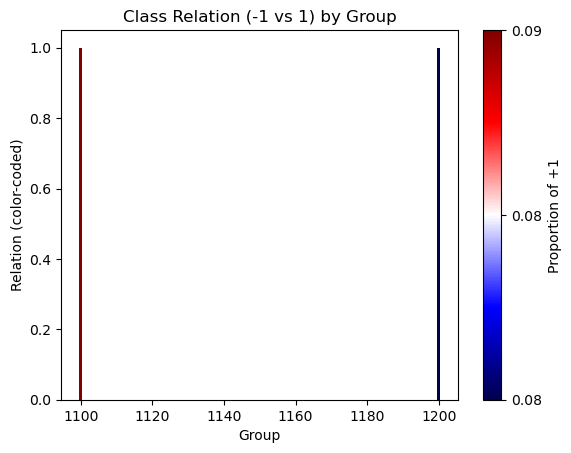

7 SEQNO


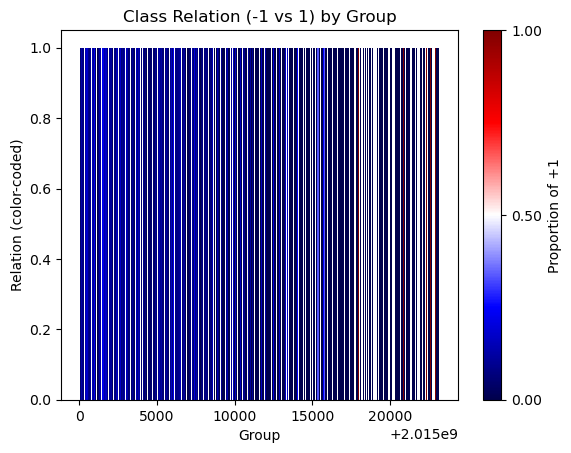

8 _PSU


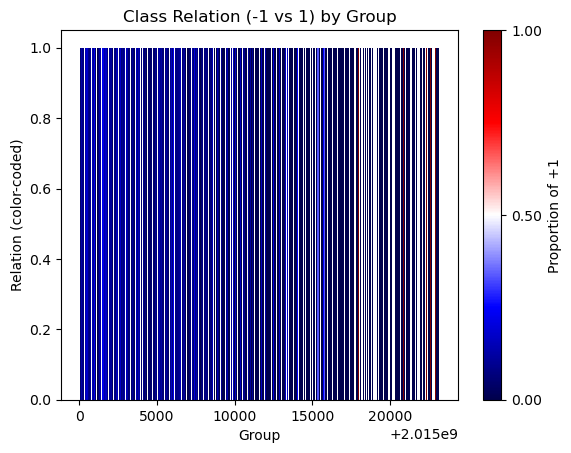

9 CTELENUM


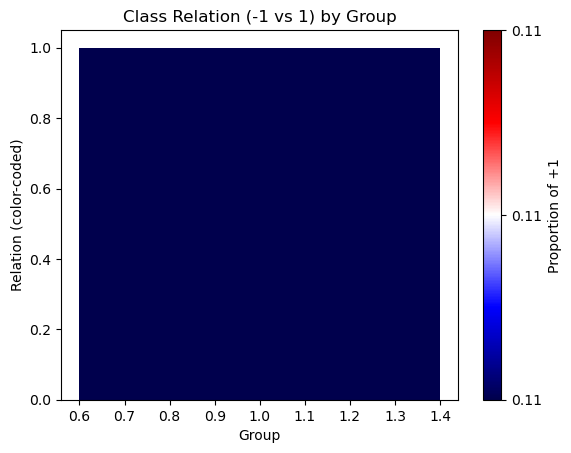

10 PVTRESD1


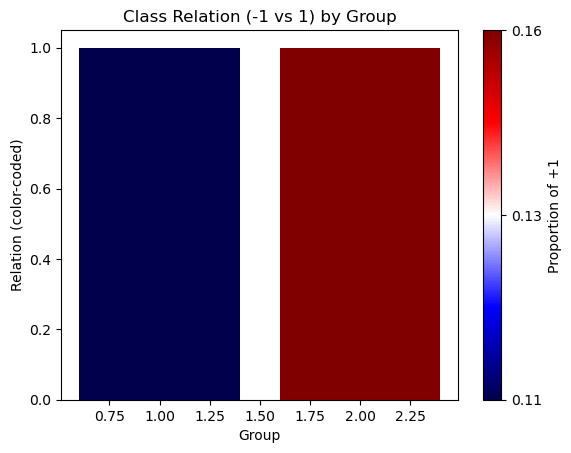

11 COLGHOUS


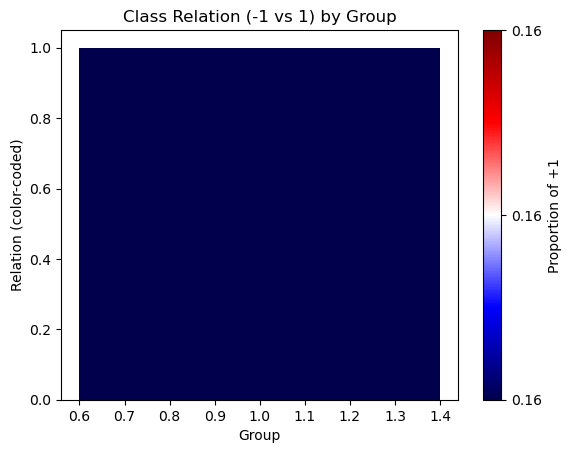

12 STATERES


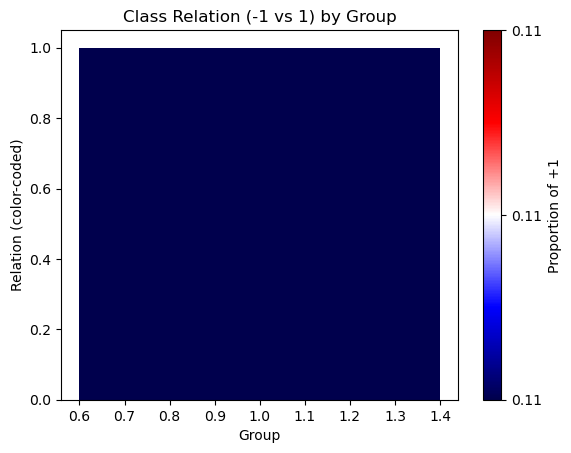

13 CELLFON3


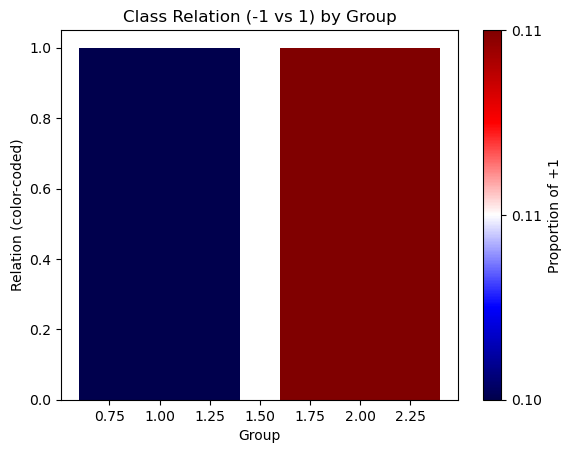

14 LADULT


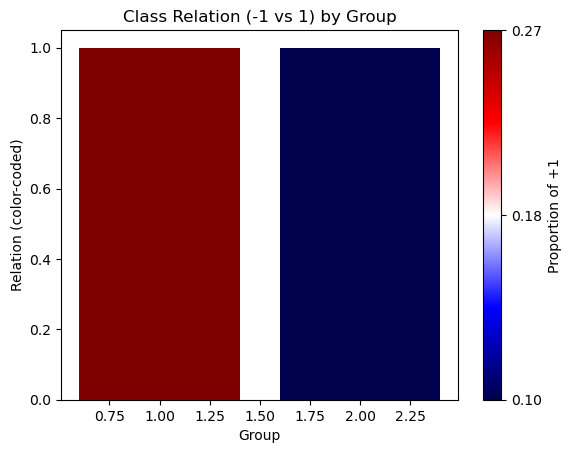

15 NUMADULT


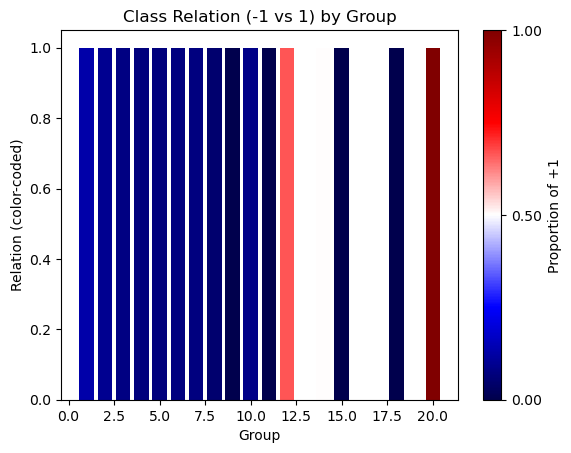

16 NUMMEN


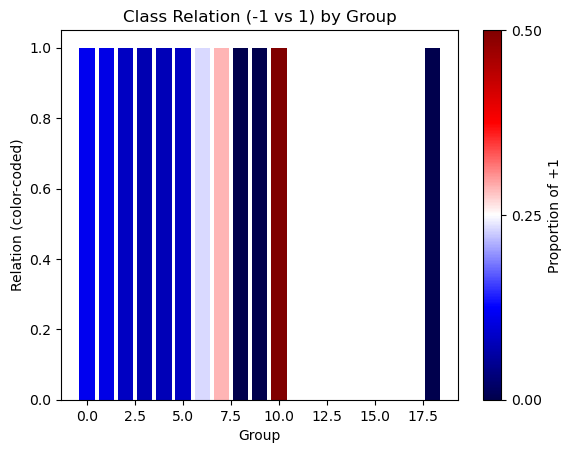

17 NUMWOMEN


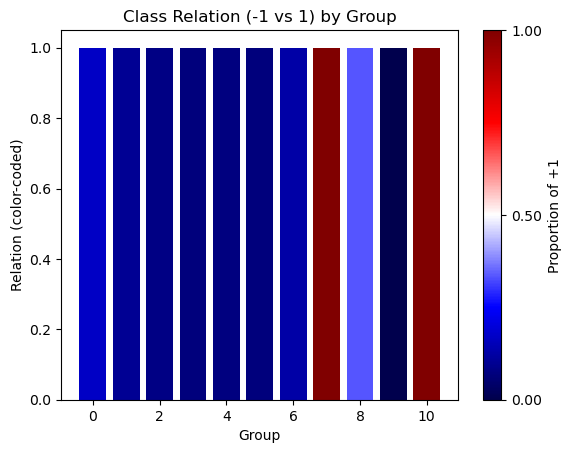

18 CTELNUM1


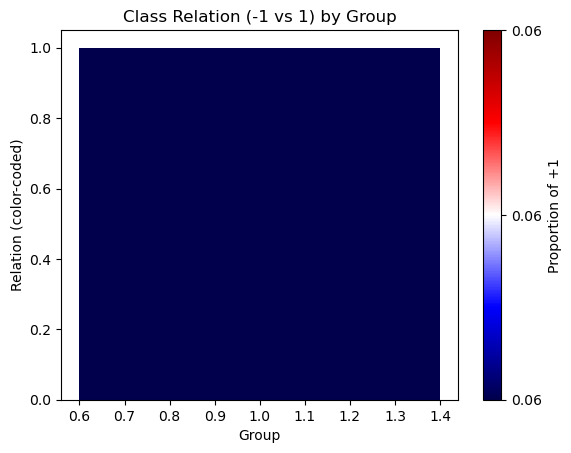

19 CELLFON2


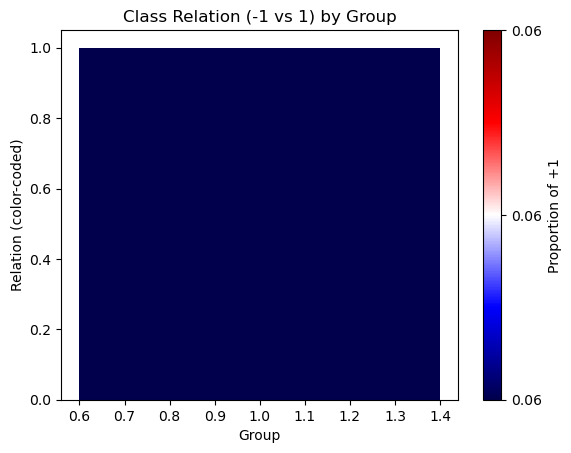

In [42]:
for i, feature_name in enumerate(feature_names[1:21]):  # Skip ID column
    print(i, feature_name)
    plot_class_distribution_by_group(y_train, x_train[:,i], annotate=False)
    plt.show()